In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

1.12.1+cu113
     |████████████████████████████████| 8.9 MB 18.3 MB/s 
     |████████████████████████████████| 3.5 MB 24.4 MB/s 
     |████████████████████████████████| 280 kB 21.6 MB/s 


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [5]:
Explainability_name = 'Evaluation of GNNs'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [6]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [7]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [8]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [9]:
def balanced_train_test_split(dataset):
  train_percent = 0.7
  index_list = []
  num_classes = dataset.num_classes

  for i in range(num_classes):
    index = (dataset.data.y == i).nonzero().view(-1)
    index = index[torch.randperm(index.size(0))]
    index_list.append(index)
    
  train_index = torch.cat([category_list[:int(len(category_list) * train_percent)] for category_list in index_list], dim=0)
  test_index = torch.cat([category_list[int(len(category_list) * train_percent):] for category_list in index_list], dim=0)

  train_index = train_index[torch.randperm(train_index.size(0))]
  test_index = test_index[torch.randperm(test_index.size(0))]

  dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
  dataset.data.test_mask = index_to_mask(test_index, size=dataset.data.num_nodes)
  
  dataset.data, dataset.slices = dataset.collate([dataset.data])

  return dataset

In [10]:
dataset2 = balanced_train_test_split(dataset)
dataset_Evaluation = dataset2[0]
print(dataset_Evaluation)
print(len(dataset_Evaluation))
print(len(dataset_Evaluation.x[dataset_Evaluation.train_mask]))
print(len(dataset_Evaluation.x[dataset_Evaluation.test_mask]))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
6
1891
817


# **GCN MODEL**

In [11]:
class GNNPool(nn.Module):
    def __init__(self):
        super().__init__()

In [12]:
class GlobalMeanPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return gnn.global_mean_pool(x, batch)

In [13]:
class IdenticalPool(GNNPool):

    def __init__(self):
        super().__init__()

    def forward(self, x, batch):
        return x

In [14]:
class GNNBasic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch


In [15]:
class GCNConv(gnn.GCNConv):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_weight = None
        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize and edge_weight is None:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
                        edge_index, edge_weight, x.size(self.node_dim),
                        self.improved, self.add_self_loops, dtype=x.dtype)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        edge_weight.requires_grad_(True)

        x = torch.matmul(x, self.weight)

        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        self.edge_weight = edge_weight

        return out

    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self._explain):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)

            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            if self._explain:
                edge_mask = self.__edge_mask__
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)


In [16]:
class GCN_2l_Model(GNNBasic):

    def __init__(self, model_level, dim_node, dim_hidden, dim_output):
        super().__init__()
        num_layer = 2

        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=False)
        self.relu1 = nn.ReLU() 
        
        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=False)
        self.relu2 = nn.ReLU()

        if model_level == 'node':
            self.readout = IdenticalPool()
        else:
            self.readout = GlobalMeanPool()

        self.ffn = nn.Linear(dim_hidden, dim_output, bias=True)

        self.dropout = nn.Dropout()

    def forward(self, *args, **kwargs) -> torch.Tensor:
        """
        :param Required[data]: Batch - input data
        :return:
        """
        x, edge_index, batch = self.arguments_read(*args, **kwargs)

        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        #out_readout1 = self.readout(post_conv1, batch)
        #print(np.shape(out_readout1))
        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
        out_readout = self.readout(post_conv2, batch)

        #print(np.shape(out_readout))
        out = self.ffn(out_readout)

        return out, post_conv2, post_conv1

    def get_emb(self, *args, **kwargs) -> torch.Tensor:
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        post_conv1 = self.relu1(self.gconv1(x, edge_index))
        post_conv2 = self.relu2(self.gconv2(x, edge_index))
            
        return post_conv2

In [17]:
GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, dim_output=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out, post_conv2, post_conv1 = GCN_Model(dataset_Evaluation.x, dataset_Evaluation.edge_index)
#visualize(out, color=data.y)


GCN_2l_Model(
  (gconv1): GCNConv(1433, 100)
  (relu1): ReLU()
  (gconv2): GCNConv(100, 100)
  (relu2): ReLU()
  (readout): IdenticalPool()
  (ffn): Linear(in_features=100, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [18]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [19]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [20]:
def loading_model(load_index):
  GCN_Model = GCN_2l_Model(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [21]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [22]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset_Evaluation.x, dataset_Evaluation.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_Evaluation.train_mask], dataset_Evaluation.y[dataset_Evaluation.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [23]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [24]:
def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, Evaluation of GNNs Model Loss: 1.9636
Epoch: 002, Evaluation of GNNs Model Loss: 1.9577
Epoch: 003, Evaluation of GNNs Model Loss: 1.9508
Epoch: 004, Evaluation of GNNs Model Loss: 1.9405
Epoch: 005, Evaluation of GNNs Model Loss: 1.9244
Epoch: 006, Evaluation of GNNs Model Loss: 1.9002
Epoch: 007, Evaluation of GNNs Model Loss: 1.8656
Epoch: 008, Evaluation of GNNs Model Loss: 1.8210
Epoch: 009, Evaluation of GNNs Model Loss: 1.7712
Epoch: 010, Evaluation of GNNs Model Loss: 1.7252
Epoch: 011, Evaluation of GNNs Model Loss: 1.6844
Epoch: 012, Evaluation of GNNs Model Loss: 1.6331
Epoch: 013, Evaluation of GNNs Model Loss: 1.5652
Epoch: 014, Evaluation of GNNs Model Loss: 1.4958
Epoch: 015, Evaluation of GNNs Model Loss: 1.4409
Epoch: 016, Evaluation of GNNs Model Loss: 1.3907
Epoch: 017, Evaluation of GNNs Model Loss: 1.3307
Epoch: 018, Evaluation of GNNs Model Loss: 1.2675
Epoch: 019, Evaluation of GNNs Model Loss: 1.2118
Epoch: 020, Evaluation of GNNs Model Loss: 1.1591


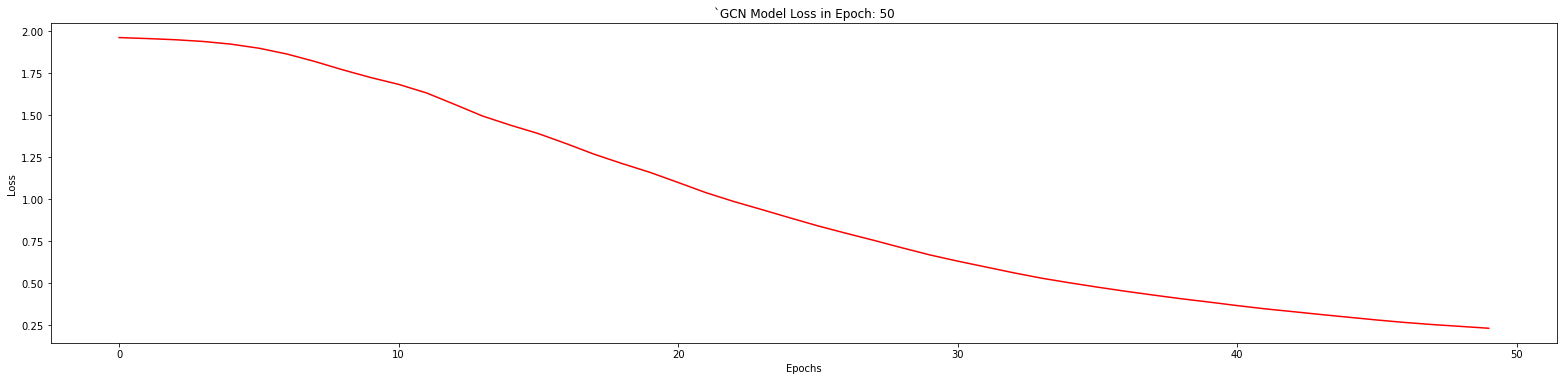

Epoch: 051, Evaluation of GNNs Model Loss: 0.2202
Epoch: 052, Evaluation of GNNs Model Loss: 0.2116
Epoch: 053, Evaluation of GNNs Model Loss: 0.2042
Epoch: 054, Evaluation of GNNs Model Loss: 0.1978
Epoch: 055, Evaluation of GNNs Model Loss: 0.1923
Epoch: 056, Evaluation of GNNs Model Loss: 0.1873
Epoch: 057, Evaluation of GNNs Model Loss: 0.1830
Epoch: 058, Evaluation of GNNs Model Loss: 0.1791
Epoch: 059, Evaluation of GNNs Model Loss: 0.1758
Epoch: 060, Evaluation of GNNs Model Loss: 0.1728
Epoch: 061, Evaluation of GNNs Model Loss: 0.1701
Epoch: 062, Evaluation of GNNs Model Loss: 0.1680
Epoch: 063, Evaluation of GNNs Model Loss: 0.1659
Epoch: 064, Evaluation of GNNs Model Loss: 0.1642
Epoch: 065, Evaluation of GNNs Model Loss: 0.1625
Epoch: 066, Evaluation of GNNs Model Loss: 0.1611
Epoch: 067, Evaluation of GNNs Model Loss: 0.1598
Epoch: 068, Evaluation of GNNs Model Loss: 0.1586
Epoch: 069, Evaluation of GNNs Model Loss: 0.1573
Epoch: 070, Evaluation of GNNs Model Loss: 0.1562


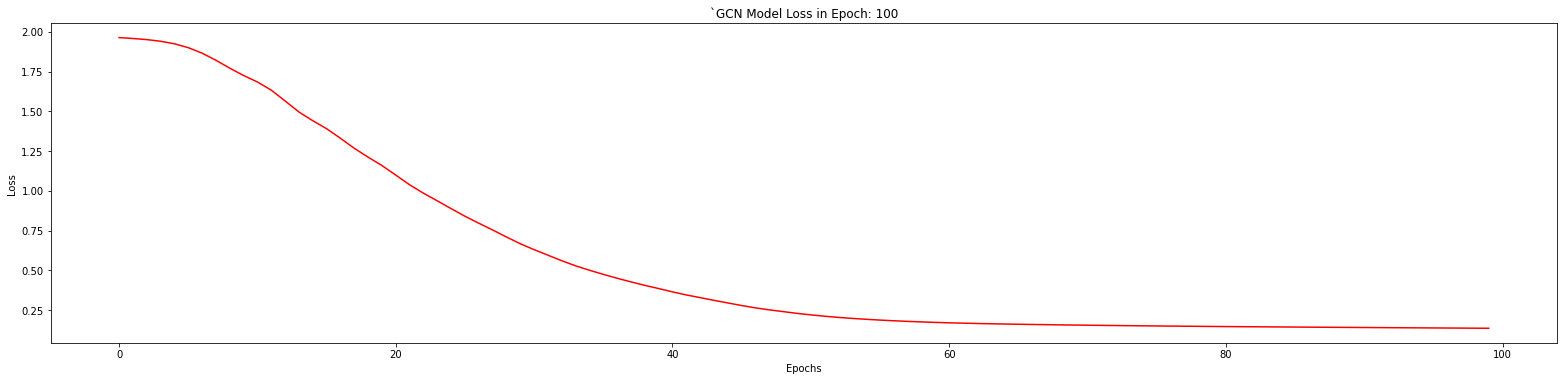

Epoch: 101, Evaluation of GNNs Model Loss: 0.1354
Epoch: 102, Evaluation of GNNs Model Loss: 0.1349
Epoch: 103, Evaluation of GNNs Model Loss: 0.1344
Epoch: 104, Evaluation of GNNs Model Loss: 0.1339
Epoch: 105, Evaluation of GNNs Model Loss: 0.1335
Epoch: 106, Evaluation of GNNs Model Loss: 0.1330
Epoch: 107, Evaluation of GNNs Model Loss: 0.1326
Epoch: 108, Evaluation of GNNs Model Loss: 0.1323
Epoch: 109, Evaluation of GNNs Model Loss: 0.1322
Epoch: 110, Evaluation of GNNs Model Loss: 0.1327
Epoch: 111, Evaluation of GNNs Model Loss: 0.1340
Epoch: 112, Evaluation of GNNs Model Loss: 0.1350
Epoch: 113, Evaluation of GNNs Model Loss: 0.1330
Epoch: 114, Evaluation of GNNs Model Loss: 0.1296
Epoch: 115, Evaluation of GNNs Model Loss: 0.1296
Epoch: 116, Evaluation of GNNs Model Loss: 0.1311
Epoch: 117, Evaluation of GNNs Model Loss: 0.1298
Epoch: 118, Evaluation of GNNs Model Loss: 0.1278
Epoch: 119, Evaluation of GNNs Model Loss: 0.1284
Epoch: 120, Evaluation of GNNs Model Loss: 0.1291


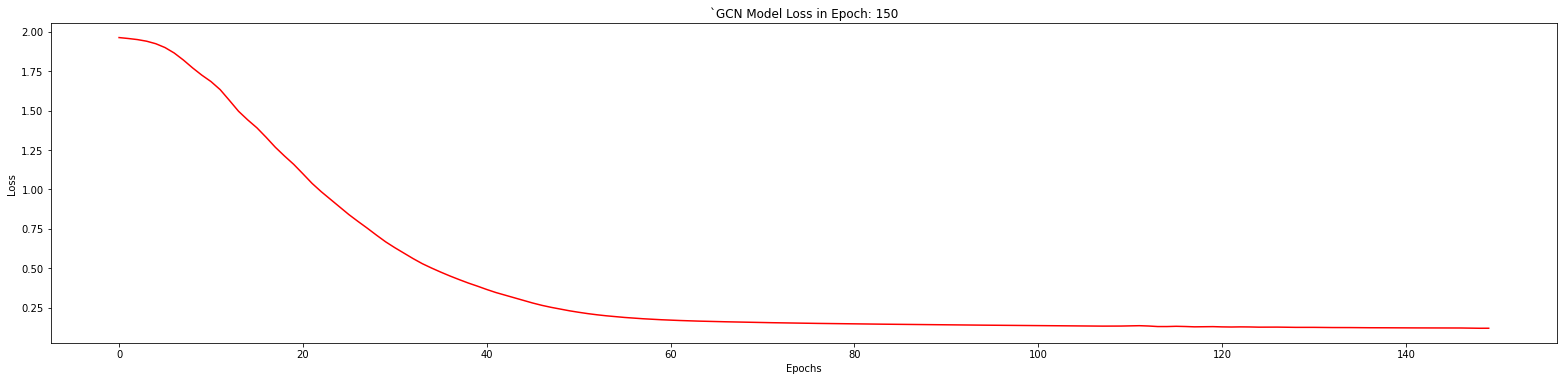

Epoch: 151, Evaluation of GNNs Model Loss: 0.1192
Epoch: 152, Evaluation of GNNs Model Loss: 0.1187
Epoch: 153, Evaluation of GNNs Model Loss: 0.1180
Epoch: 154, Evaluation of GNNs Model Loss: 0.1176
Epoch: 155, Evaluation of GNNs Model Loss: 0.1177
Epoch: 156, Evaluation of GNNs Model Loss: 0.1178
Epoch: 157, Evaluation of GNNs Model Loss: 0.1173
Epoch: 158, Evaluation of GNNs Model Loss: 0.1168
Epoch: 159, Evaluation of GNNs Model Loss: 0.1166
Epoch: 160, Evaluation of GNNs Model Loss: 0.1166
Epoch: 161, Evaluation of GNNs Model Loss: 0.1166
Epoch: 162, Evaluation of GNNs Model Loss: 0.1162
Epoch: 163, Evaluation of GNNs Model Loss: 0.1158
Epoch: 164, Evaluation of GNNs Model Loss: 0.1156
Epoch: 165, Evaluation of GNNs Model Loss: 0.1155
Epoch: 166, Evaluation of GNNs Model Loss: 0.1154
Epoch: 167, Evaluation of GNNs Model Loss: 0.1152
Epoch: 168, Evaluation of GNNs Model Loss: 0.1149
Epoch: 169, Evaluation of GNNs Model Loss: 0.1146
Epoch: 170, Evaluation of GNNs Model Loss: 0.1144


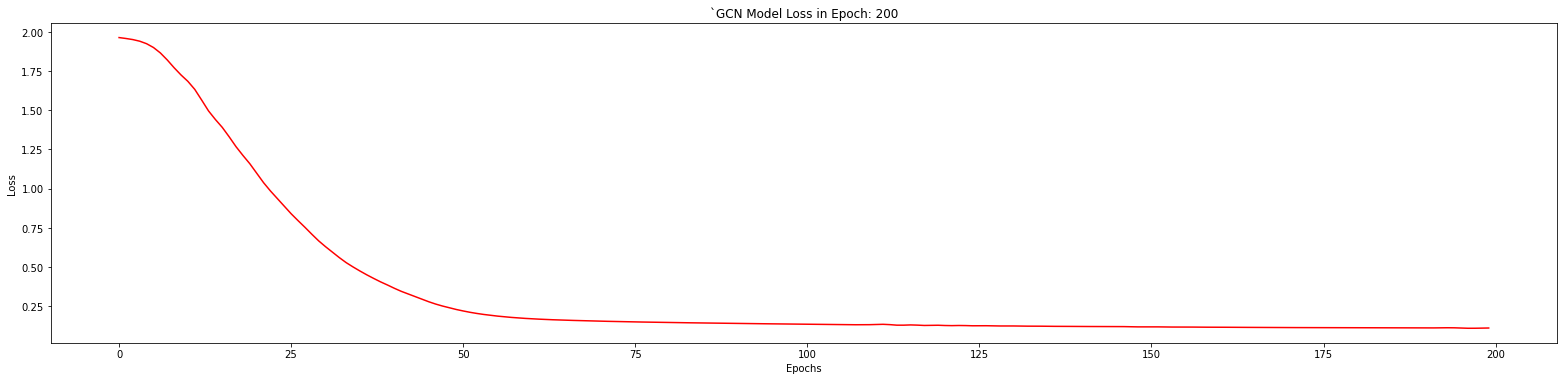

In [25]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [26]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out, post_conv2, post_conv1 = GCN_Model(dataset_Evaluation.x, dataset_Evaluation.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_Evaluation.test_mask] == dataset_Evaluation.y[dataset_Evaluation.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_Evaluation.test_mask.sum())
  return GCN_Model_test_acc

In [27]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8690


In [28]:
GCN_Model.eval()

GCN_Model_test_out, post_conv2, post_conv1 = GCN_Model(dataset_Evaluation.x, dataset_Evaluation.edge_index)
#visualize(GCN_Model_test_out, color = dataset_PGExplainer.y)

## **Evaluation of the GNN**

In [29]:
GCN_Model_state = GCN_Model.state_dict()
print(GCN_Model_state.keys())

odict_keys(['gconv1.weight', 'gconv1.lin.weight', 'gconv2.weight', 'gconv2.lin.weight', 'ffn.weight', 'ffn.bias'])


In [30]:
def GCN_Model_Evaluation(test_dataset):
  GCN_Outputs = []
  GCN_Preds = []

  GCN_Model.eval()

  #for batch_of_graphs in test_dataset:
  GCN_Model_test_activations, post_conv2_test_activations, post_conv1_test_activations = GCN_Model(test_dataset.x, test_dataset.edge_index)
  GCN_Model_test_activations = GCN_Model_test_activations[dataset_Evaluation.test_mask]
  GCN_Model_test_pred = GCN_Model_test_activations.argmax(dim=1)

  GCN_Outputs.append(GCN_Model_test_activations.detach().tolist())  
  GCN_Preds.append(GCN_Model_test_pred.detach().tolist())  
    
  return GCN_Outputs, GCN_Preds

In [31]:
GCN_Outputs, GCN_Preds = GCN_Model_Evaluation(dataset_Evaluation)

In [32]:
print(GCN_Outputs)
print(len(GCN_Outputs))
print(len(GCN_Outputs[0]))
print(np.shape(GCN_Outputs))

[[[-2.7061100006103516, -1.270355224609375, 4.807577133178711, 0.8618898391723633, -2.0019609928131104, 1.0953772068023682, -8.368311882019043], [-1.162635326385498, -0.9305145740509033, -1.9037513732910156, 4.211960315704346, -1.5445919036865234, -3.237868547439575, -3.1423287391662598], [-0.2719138562679291, 0.9069265127182007, 7.612239837646484, 0.0666334331035614, -4.854599952697754, 0.6028757691383362, -10.085684776306152], [-1.8431870937347412, 5.92695426940918, -0.09059985727071762, -1.7134008407592773, -9.050230979919434, 1.324806571006775, -1.5697500705718994], [-4.864598751068115, -0.6488461494445801, 0.6633763313293457, -2.366607666015625, -2.129520893096924, 5.018293380737305, -2.7520298957824707], [-0.5554563403129578, -5.322819709777832, -5.125837326049805, -0.37653377652168274, 3.8307607173919678, -0.6007233262062073, 1.018926978111267], [-2.5834286212921143, -11.40182113647461, -3.4123587608337402, 1.0323905944824219, 9.523711204528809, -0.7591965794563293, -3.366996765

## **Apply Sigmoid**

In [33]:
def sig(predictions):
  Preds = []
  for i in range(len(predictions)):
    Preds.append([1/(1 + np.exp(-predictions[i][0])), 1/(1 + np.exp(-predictions[i][1])), 1/(1 + np.exp(-predictions[i][2])), 1/(1 + np.exp(-predictions[i][3])), 1/(1 + np.exp(-predictions[i][4])), 1/(1 + np.exp(-predictions[i][5])), 1/(1 + np.exp(-predictions[i][6]))])
  return Preds

In [34]:
sig_preds = sig(GCN_Outputs[0])

In [35]:
print(sig_preds)

[[0.06261378016777486, 0.21919644955685713, 0.9918985448351543, 0.7030553446267945, 0.11899718405448742, 0.7493929317007141, 0.0002320531861016576], [0.23818876245121492, 0.28282033025000575, 0.12968448179115974, 0.9853990532338078, 0.17586873830614927, 0.03776526921233592, 0.04139461361923399], [0.43243730657811025, 0.7123708206839701, 0.9995058809504475, 0.5166521973987521, 0.007732197316894063, 0.6463139609561935, 4.16701110608853e-05], [0.13667479645335365, 0.9973405004466159, 0.4773655161818103, 0.15272313121168618, 0.0001173501524036396, 0.789980283144549, 0.17225202406874768], [0.007655858812596331, 0.34324960199834914, 0.660018426121345, 0.08575472784289921, 0.10626048348859031, 0.9934276735032453, 0.05997211160297578], [0.36459942529914213, 0.004855288172633354, 0.005906150656109214, 0.40696317929795633, 0.9787674920399895, 0.3541782255779661, 0.7347635351188117], [0.07021257091429216, 1.1174990008856952e-05, 0.031911447527722, 0.7373790998721851, 0.9999269074637523, 0.3188207

## **Seven Binary Classes**

In [36]:
Train_Index_List = []
for i in range(len(dataset_Evaluation.train_mask)):
  if dataset_Evaluation.train_mask[i]:
    Train_Index_List.append(i)

Test_Index_List = []
for i in range(len(dataset_Evaluation.test_mask)):
  if dataset_Evaluation.test_mask[i]:
    Test_Index_List.append(i)

In [37]:
Index_Class1 = []
Index_Class2 = []
Index_Class3 = []
Index_Class4 = []
Index_Class5 = []
Index_Class6 = []
Index_Class7 = []

In [38]:
for i in range(len(Test_Index_List)):
  if dataset_Evaluation.y[Test_Index_List[i]] == 0:
    Index_Class1.append(Test_Index_List[i])
  elif dataset_Evaluation.y[Test_Index_List[i]] == 1:
    Index_Class2.append(Test_Index_List[i])
  elif dataset_Evaluation.y[Test_Index_List[i]] == 2:
    Index_Class3.append(Test_Index_List[i])
  elif dataset_Evaluation.y[Test_Index_List[i]] == 3:
    Index_Class4.append(Test_Index_List[i])
  elif dataset_Evaluation.y[Test_Index_List[i]] == 4:
    Index_Class5.append(Test_Index_List[i])
  elif dataset_Evaluation.y[Test_Index_List[i]] == 5:
    Index_Class6.append(Test_Index_List[i])
  elif dataset_Evaluation.y[Test_Index_List[i]] == 6:
    Index_Class7.append(Test_Index_List[i])

In [39]:
print(len(Index_Class1), len(Index_Class2), len(Index_Class3), len(Index_Class4), len(Index_Class5), len(Index_Class6), len(Index_Class7))

106 66 126 246 128 90 55


## **GCN Model Output for nodes in each class**

In [40]:
GCN_Output_Class1 = [0] * len(GCN_Outputs[0])
GCN_Output_Class2 = [0] * len(GCN_Outputs[0])
GCN_Output_Class3 = [0] * len(GCN_Outputs[0])
GCN_Output_Class4 = [0] * len(GCN_Outputs[0])
GCN_Output_Class5 = [0] * len(GCN_Outputs[0])
GCN_Output_Class6 = [0] * len(GCN_Outputs[0])
GCN_Output_Class7 = [0] * len(GCN_Outputs[0])

Real_Binary_Label_Class1 = [0] * len(GCN_Outputs[0])
Real_Binary_Label_Class2 = [0] * len(GCN_Outputs[0])
Real_Binary_Label_Class3 = [0] * len(GCN_Outputs[0])
Real_Binary_Label_Class4 = [0] * len(GCN_Outputs[0])
Real_Binary_Label_Class5 = [0] * len(GCN_Outputs[0])
Real_Binary_Label_Class6 = [0] * len(GCN_Outputs[0])
Real_Binary_Label_Class7 = [0] * len(GCN_Outputs[0])

In [41]:
print(np.shape(sig_preds))

(817, 7)


In [42]:
for i in range(len(Test_Index_List)):
  if dataset_Evaluation.y[Test_Index_List[i]] == 0:
    GCN_Output_Class1[i] = sig_preds[i][0]
    Real_Binary_Label_Class1[i] = 1

  elif dataset_Evaluation.y[Test_Index_List[i]] == 1:
    GCN_Output_Class2[i] = sig_preds[i][1]
    Real_Binary_Label_Class2[i] = 1

  elif dataset_Evaluation.y[Test_Index_List[i]] == 2:
    GCN_Output_Class3[i] = sig_preds[i][2]
    Real_Binary_Label_Class3[i] = 1

  elif dataset_Evaluation.y[Test_Index_List[i]] == 3:
    GCN_Output_Class4[i] = sig_preds[i][3]
    Real_Binary_Label_Class4[i] = 1

  elif dataset_Evaluation.y[Test_Index_List[i]] == 4:
    GCN_Output_Class5[i] = sig_preds[i][4]
    Real_Binary_Label_Class5[i] = 1

  elif dataset_Evaluation.y[Test_Index_List[i]] == 5:
    GCN_Output_Class6[i] = sig_preds[i][5]
    Real_Binary_Label_Class6[i] = 1

  elif dataset_Evaluation.y[Test_Index_List[i]] == 6:
    GCN_Output_Class7[i] = sig_preds[i][6]
    Real_Binary_Label_Class7[i] = 1

In [43]:
print(np.shape(GCN_Output_Class1))
print(np.shape(GCN_Output_Class2))
print(np.shape(GCN_Output_Class3))
print(np.shape(GCN_Output_Class4))
print(np.shape(GCN_Output_Class5))
print(np.shape(GCN_Output_Class6))
print(np.shape(GCN_Output_Class7))

(817,)
(817,)
(817,)
(817,)
(817,)
(817,)
(817,)


In [44]:
print(GCN_Output_Class1)
print(GCN_Output_Class2)
print(GCN_Output_Class3)
print(GCN_Output_Class4)
print(GCN_Output_Class5)
print(GCN_Output_Class6)
print(GCN_Output_Class7)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5767750505961704, 0, 0.9572247179168102, 0, 0, 0, 0, 0.99927853898583, 0, 0, 0, 0.5815502287551437, 0, 0, 0, 0.9455672153575565, 0.9714840976073631, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9919670402693228, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7620214713553788, 0, 0, 0.9062258425833905, 0, 0, 0, 0, 0, 0, 0, 0, 0.9987206425584344, 0, 0.9315375524284679, 0, 0, 0, 0.9993369965055976, 0, 0.984118526665263, 0, 0, 0, 0, 0, 0, 0, 0.8260298767197527, 0.9951721549311443, 0.9536905068832378, 0, 0, 0, 0, 0, 0, 0, 0, 0.3758156312085207, 0, 0, 0, 0, 0, 0.874247917905981, 0, 0, 0, 0, 0, 0, 0.9993773058454475, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9800926862114909, 0, 0, 0, 0, 0, 0, 0, 0.999865349582333, 0, 0, 0, 0, 0, 0, 0, 0.33718917295196116, 0, 0, 0.978426290887881, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9828543999306644, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9982371857650845, 0, 0, 0.5634226927791641, 0, 0, 0, 0, 0

In [45]:
print(Real_Binary_Label_Class1)
print(Real_Binary_Label_Class2)
print(Real_Binary_Label_Class3)
print(Real_Binary_Label_Class4)
print(Real_Binary_Label_Class5)
print(Real_Binary_Label_Class6)
print(Real_Binary_Label_Class7)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

## **Evaluations**

In [46]:
def Evaluations(y, prob):
    TPR_List = []
    FPR_List = []
    Precision_List = []
    NPV_List = []
    Acc_List = []
    F1Score_List = []

    threshold = np.linspace(1, 0, 10)
    for t in threshold:
        y_pred = np.zeros(y.shape[0])
        y_pred[prob >= t] = 1

        TN = y_pred[(y_pred == y) & (y == 0)].shape[0]
        TP = y_pred[(y_pred == y) & (y == 1)].shape[0]
        FP = y_pred[(y_pred != y) & (y == 0)].shape[0]
        FN = y_pred[(y_pred != y) & (y == 1)].shape[0]

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        TNR = TN / (TN + FP)
        FNR = FN / (FN + TP)

        Precision = TP / (TP + FP + 1e-10)
        NPV = TN / (TN + FN + 1e-10)
        FDR = FP / (FP + TP + 1e-10)
        FOR = FN / (FN + TN + 1e-10)
        PLR = TPR / (FPR + 1e-10)
        NLR = FNR / (TNR + 1e-10)
        Acc = (TP + TN) / (TP + TN + FP + FN)
        F1Score = (2 * TP) / (2*TP + FP + FN)

        TPR_List.append(TPR)
        FPR_List.append(FPR)
        Precision_List.append(Precision)
        NPV_List.append(NPV)
        Acc_List.append(Acc)
        F1Score_List.append(F1Score)

    return FPR_List, TPR_List, threshold, Precision_List, NPV_List, Acc_List, F1Score_List

In [47]:
fpr1, tpr1, threshold1, precision_list1, npv_list1, acc_list1, f1score_list1 = Evaluations(np.array(Real_Binary_Label_Class1), np.array(GCN_Output_Class1))

In [48]:
fpr2, tpr2, threshold2, precision_list2, npv_list2, acc_list2, f1score_list2 = Evaluations(np.array(Real_Binary_Label_Class2), np.array(GCN_Output_Class2))

In [49]:
fpr3, tpr3, threshold3, precision_list3, npv_list3, acc_list3, f1score_list3 = Evaluations(np.array(Real_Binary_Label_Class3), np.array(GCN_Output_Class3))

In [50]:
fpr4, tpr4, threshold4, precision_list4, npv_list4, acc_list4, f1score_list4 = Evaluations(np.array(Real_Binary_Label_Class4), np.array(GCN_Output_Class4))

In [51]:
fpr5, tpr5, threshold5, precision_list5, npv_list5, acc_list5, f1score_list5 = Evaluations(np.array(Real_Binary_Label_Class5), np.array(GCN_Output_Class5))

In [52]:
fpr6, tpr6, threshold6, precision_list6, npv_list6, acc_list6, f1score_list6 = Evaluations(np.array(Real_Binary_Label_Class6), np.array(GCN_Output_Class6))

In [53]:
fpr7, tpr7, threshold7, precision_list7, npv_list7, acc_list7, f1score_list7 = Evaluations(np.array(Real_Binary_Label_Class7), np.array(GCN_Output_Class7))

## **Plotting**

In [54]:
def Evaluation_Plots(EVs, class_index):
  fig1 = plt.figure(figsize=(30,10))

  ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC on class " + str(class_index) + ", The GNN is trained on " + str(EPOCHS) + " Epochs")

  ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=1)
  plt.xlabel("Thresholds")
  plt.ylabel("Probabilistic Values")
  plt.title("Thresholds on class " + str(class_index) + ", The GNN is trained on " + str(EPOCHS) + " Epochs") 

  ax3 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
  plt.xlabel("Thresholds")
  plt.ylabel('Precision')
  plt.title("Precision on class " + str(class_index) + ", The GNN is trained on " + str(EPOCHS) + " Epochs")

  ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
  plt.xlabel("Thresholds")
  plt.ylabel("Negative Predictive Value")
  plt.title("NPV on class " + str(class_index) + ", The GNN is trained on " + str(EPOCHS) + " Epochs")

  ax5 = plt.subplot2grid((2, 3), (1, 1), colspan=1)
  plt.xlabel("Thresholds")
  plt.ylabel("Accuracy")
  plt.title("Accuracy on class " + str(class_index) + ", The GNN is trained on " + str(EPOCHS) + " Epochs")

  ax6 = plt.subplot2grid((2, 3), (1, 2), colspan=1)
  plt.xlabel("Thresholds")
  plt.ylabel("F1Score")
  plt.title("F1Score on class " + str(class_index) + ", The GNN is trained on " + str(EPOCHS) + " Epochs")



  ax1.plot(EVs[0], EVs[1], color='r')
  ax1.plot([0,1], [0,1], 'g--')
  
  ax2.plot(EVs[2], color='r') #threshold
  ax3.plot(EVs[2], EVs[3], color='r') #precision
  ax4.plot(EVs[2], EVs[4], color='r') #NPV
  ax5.plot(EVs[2], EVs[5], color='r') #Accuracy
  ax6.plot(EVs[2], EVs[6], color='r') #F1Score

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Evaluations on class " + str(class_index) + ".png")
  plt.show()

## **Class One**

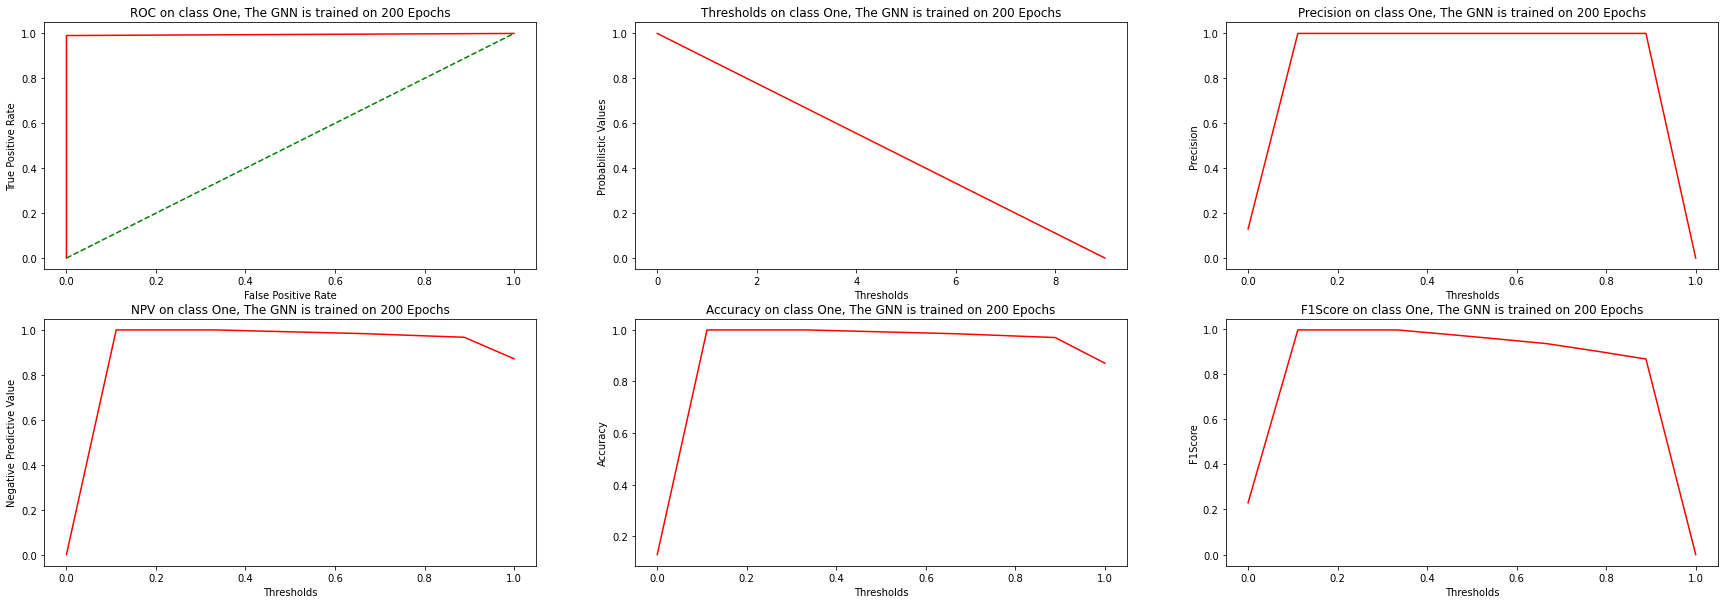

FPR:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 10
TPR:  [0.0, 0.7641509433962265, 0.8207547169811321, 0.8773584905660378, 0.9150943396226415, 0.9528301886792453, 0.9905660377358491, 0.9905660377358491, 0.9905660377358491, 1.0] 10
Threshold:  [1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ] 10
Precision:  [0.0, 0.9999999999987654, 0.9999999999988506, 0.9999999999989247, 0.999999999998969, 0.9999999999990099, 0.9999999999990477, 0.9999999999990477, 0.9999999999990477, 0.12974296205628766] 10
NPV:  [0.8702570379435899, 0.9660326086955209, 0.9739726027395925, 0.9820441988948919, 0.9874999999998628, 0.9930167597763976, 0.9985955056178372, 0.9985955056178372, 0.9985955056178372, 0.0] 10
Accuracy:  [0.8702570379436965, 0.9694002447980417, 0.9767441860465116, 0.9840881272949816, 0.988984088127295, 0.9938800489596084, 0.9987760097919217, 0.9987760097919217, 0.9987760097919217, 0.12974296205630356] 10
F1Score:  [0.0, 0.866

In [62]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr1, tpr1, threshold1, precision_list1, npv_list1, acc_list1, f1score_list1],"One")

print("FPR: ", fpr1, len(fpr1))
print("TPR: ", tpr1, len(tpr1))
print("Threshold: ", threshold1, len(threshold1))
print("Precision: ", precision_list1, len(precision_list1))
print("NPV: ", npv_list1, len(npv_list1))
print("Accuracy: ", acc_list1, len(acc_list1))
print("F1Score: ", f1score_list1, len(f1score_list1))

## **Class Two**

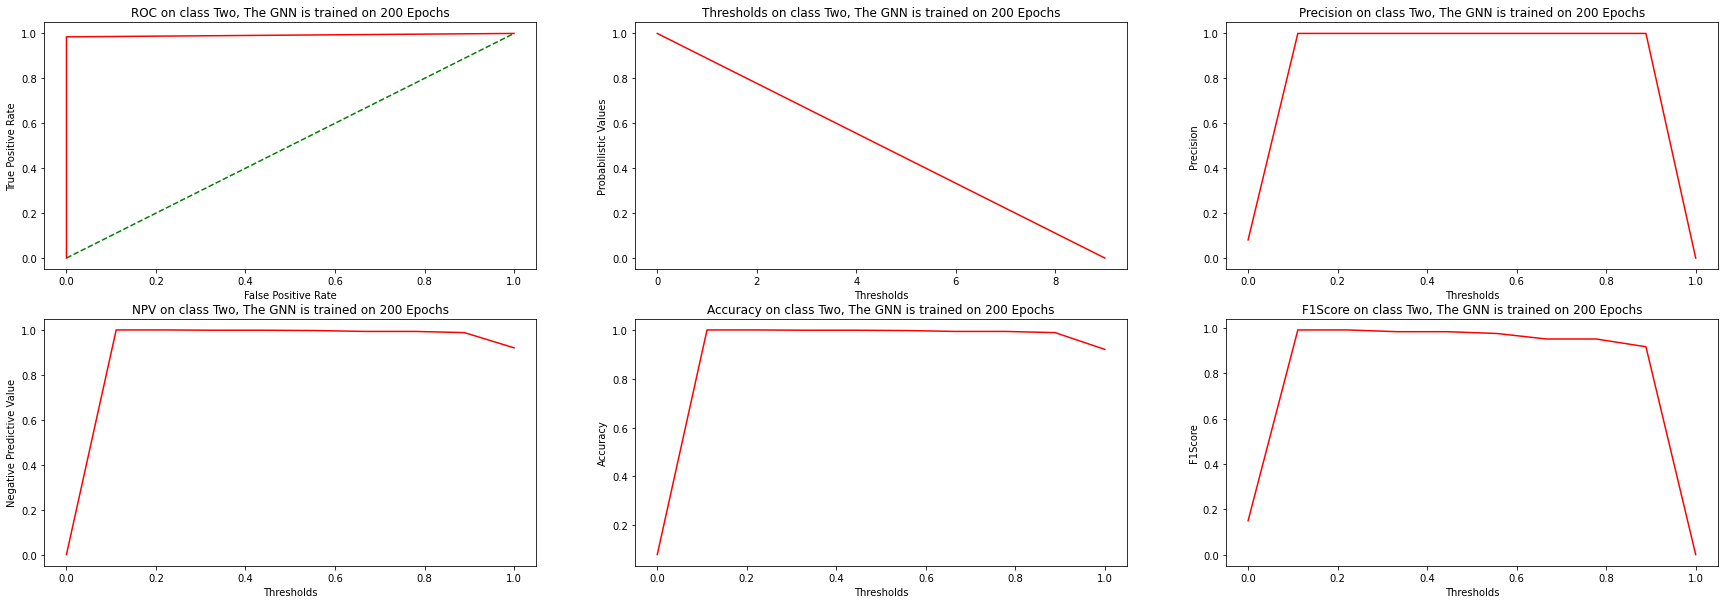

FPR:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 10
TPR:  [0.0, 0.8484848484848485, 0.9090909090909091, 0.9090909090909091, 0.9545454545454546, 0.9696969696969697, 0.9696969696969697, 0.9848484848484849, 0.9848484848484849, 1.0] 10
Threshold:  [1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ] 10
Precision:  [0.0, 0.9999999999982142, 0.9999999999983333, 0.9999999999983333, 0.9999999999984127, 0.9999999999984375, 0.9999999999984375, 0.9999999999984616, 0.9999999999984616, 0.08078335373316024] 10
NPV:  [0.9192166462667173, 0.9868593955320647, 0.9920739762217976, 0.9920739762217976, 0.9960212201590191, 0.9973439575031875, 0.9973439575031875, 0.9986702127658246, 0.9986702127658246, 0.0] 10
Accuracy:  [0.9192166462668299, 0.9877600979192166, 0.99265605875153, 0.99265605875153, 0.996328029375765, 0.9975520195838433, 0.9975520195838433, 0.9987760097919217, 0.9987760097919217, 0.08078335373317014] 10
F1Score:  [0.0, 0.918032

In [63]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr2, tpr2, threshold2, precision_list2, npv_list2, acc_list2, f1score_list2],"Two")

print("FPR: ", fpr2, len(fpr2))
print("TPR: ", tpr2, len(tpr2))
print("Threshold: ", threshold2, len(threshold2))
print("Precision: ", precision_list2, len(precision_list2))
print("NPV: ", npv_list2, len(npv_list2))
print("Accuracy: ", acc_list2, len(acc_list2))
print("F1Score: ", f1score_list2, len(f1score_list2))

## **Class Three**

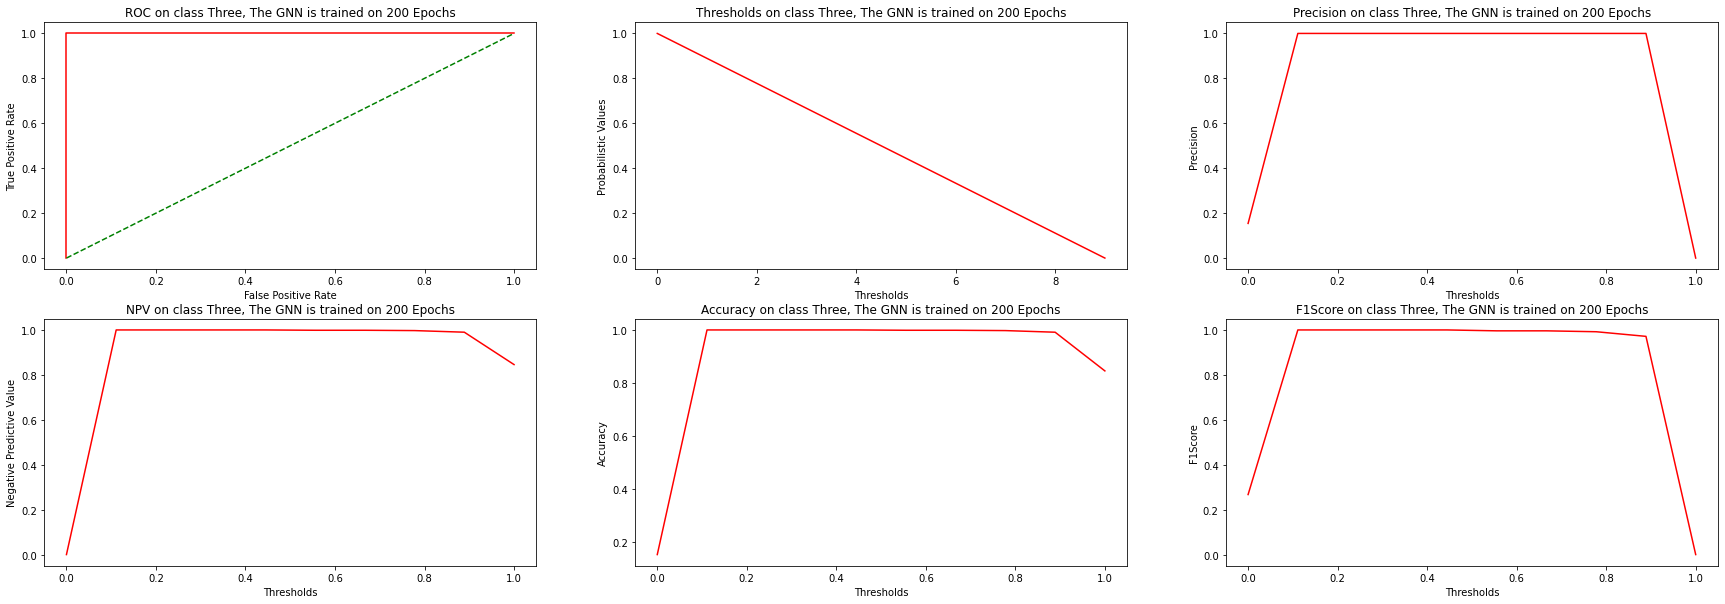

FPR:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 10
TPR:  [0.0, 0.9444444444444444, 0.9841269841269841, 0.9920634920634921, 0.9920634920634921, 1.0, 1.0, 1.0, 1.0, 1.0] 10
Threshold:  [1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ] 10
Precision:  [0.0, 0.9999999999991597, 0.9999999999991935, 0.9999999999992, 0.9999999999992, 0.9999999999992063, 0.9999999999992063, 0.9999999999992063, 0.9999999999992063, 0.15422276621785136] 10
NPV:  [0.8457772337820262, 0.9899713467047292, 0.9971139971138532, 0.9985549132946533, 0.9985549132946533, 0.9999999999998552, 0.9999999999998552, 0.9999999999998552, 0.9999999999998552, 0.0] 10
Accuracy:  [0.8457772337821298, 0.9914320685434517, 0.9975520195838433, 0.9987760097919217, 0.9987760097919217, 1.0, 1.0, 1.0, 1.0, 0.15422276621787026] 10
F1Score:  [0.0, 0.9714285714285714, 0.992, 0.9960159362549801, 0.9960159362549801, 1.0, 1.0, 1.0, 1.0, 0.2672322375397667] 10


In [64]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr3, tpr3, threshold3, precision_list3, npv_list3, acc_list3, f1score_list3],"Three")

print("FPR: ", fpr3, len(fpr3))
print("TPR: ", tpr3, len(tpr3))
print("Threshold: ", threshold3, len(threshold3))
print("Precision: ", precision_list3, len(precision_list3))
print("NPV: ", npv_list3, len(npv_list3))
print("Accuracy: ", acc_list3, len(acc_list3))
print("F1Score: ", f1score_list3, len(f1score_list3))

## **Class Four**

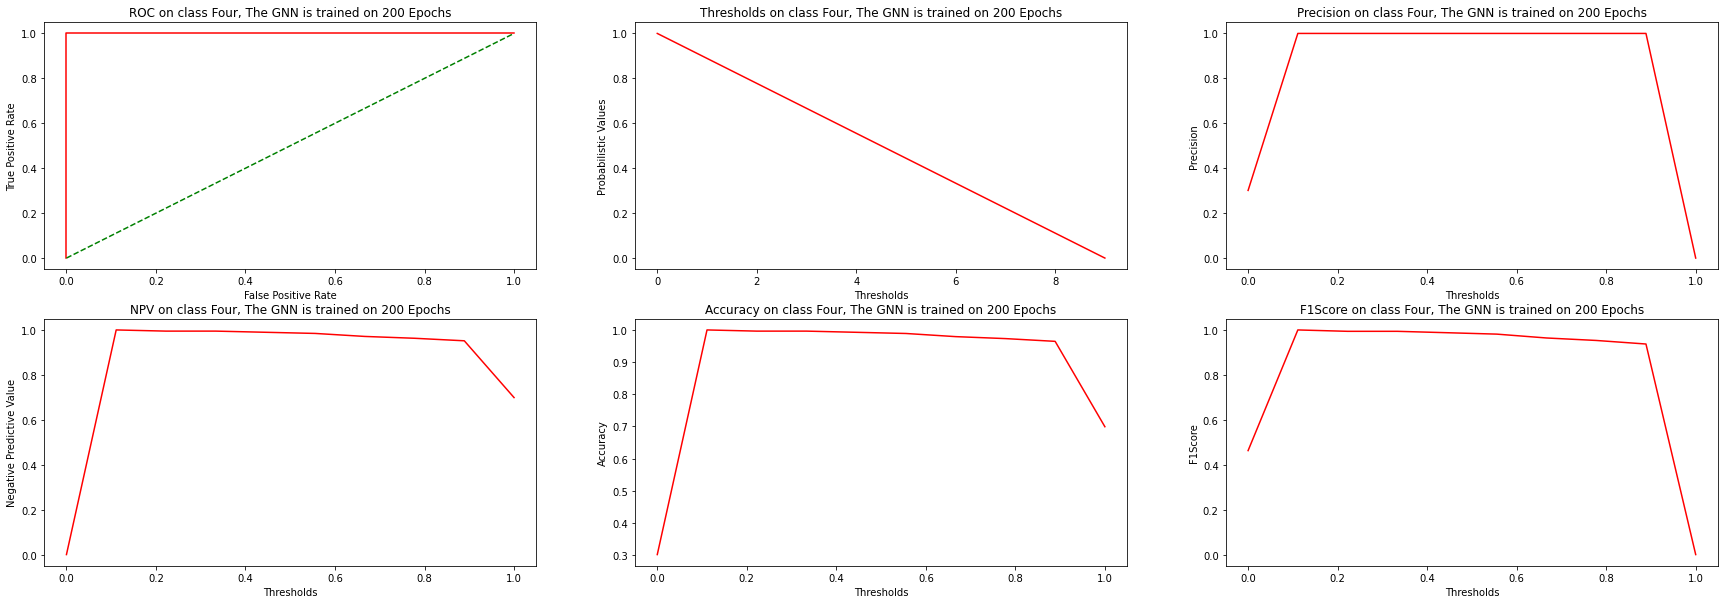

FPR:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 10
TPR:  [0.0, 0.8821138211382114, 0.9105691056910569, 0.9308943089430894, 0.9634146341463414, 0.975609756097561, 0.9878048780487805, 0.9878048780487805, 1.0, 1.0] 10
Threshold:  [1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ] 10
Precision:  [0.0, 0.9999999999995393, 0.9999999999995536, 0.9999999999995633, 0.9999999999995781, 0.9999999999995833, 0.9999999999995886, 0.9999999999995886, 0.9999999999995935, 0.3011015911872336] 10
NPV:  [0.6988984088126439, 0.951666666666508, 0.9629005059020298, 0.9710884353739845, 0.9844827586205198, 0.9896013864816309, 0.9947735191635897, 0.9947735191635897, 0.9999999999998248, 0.0] 10
Accuracy:  [0.6988984088127295, 0.9645042839657283, 0.9730722154222766, 0.9791921664626683, 0.988984088127295, 0.99265605875153, 0.996328029375765, 0.996328029375765, 1.0, 0.3011015911872705] 10
F1Score:  [0.0, 0.937365010799136, 0.9531914893617022, 0.9

In [65]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr4, tpr4, threshold4, precision_list4, npv_list4, acc_list4, f1score_list4],"Four")

print("FPR: ", fpr4, len(fpr4))
print("TPR: ", tpr4, len(tpr4))
print("Threshold: ", threshold4, len(threshold4))
print("Precision: ", precision_list4, len(precision_list4))
print("NPV: ", npv_list4, len(npv_list4))
print("Accuracy: ", acc_list4, len(acc_list4))
print("F1Score: ", f1score_list4, len(f1score_list4))

## **Class Five**

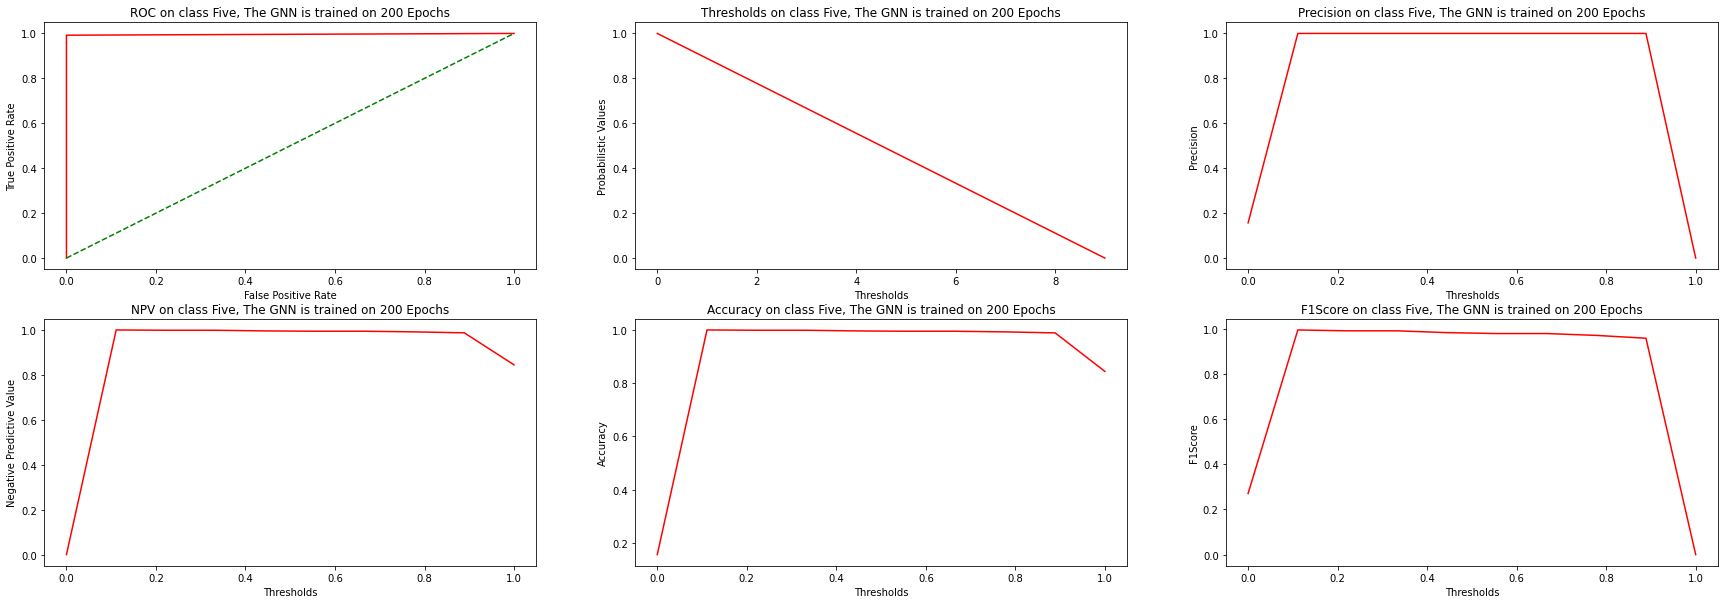

FPR:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 10
TPR:  [0.0, 0.921875, 0.9453125, 0.9609375, 0.9609375, 0.96875, 0.984375, 0.984375, 0.9921875, 1.0] 10
Threshold:  [1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ] 10
Precision:  [0.0, 0.9999999999991526, 0.9999999999991735, 0.999999999999187, 0.999999999999187, 0.9999999999991935, 0.9999999999992063, 0.9999999999992063, 0.9999999999992126, 0.15667074663400773] 10
NPV:  [0.8433292533658698, 0.9856938483546515, 0.9899425287354899, 0.9927953890488482, 0.9927953890488482, 0.9942279942278507, 0.9971056439940669, 0.9971056439940669, 0.9985507246375364, 0.0] 10
Accuracy:  [0.8433292533659731, 0.9877600979192166, 0.9914320685434517, 0.9938800489596084, 0.9938800489596084, 0.9951040391676866, 0.9975520195838433, 0.9975520195838433, 0.9987760097919217, 0.15667074663402691] 10
F1Score:  [0.0, 0.959349593495935, 0.9718875502008032, 0.9800796812749004, 0.9800796812749004, 0.9

In [66]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr5, tpr5, threshold5, precision_list5, npv_list5, acc_list5, f1score_list5],"Five")

print("FPR: ", fpr5, len(fpr5))
print("TPR: ", tpr5, len(tpr5))
print("Threshold: ", threshold5, len(threshold5))
print("Precision: ", precision_list5, len(precision_list5))
print("NPV: ", npv_list5, len(npv_list5))
print("Accuracy: ", acc_list5, len(acc_list5))
print("F1Score: ", f1score_list5, len(f1score_list5))

## **Class Six**

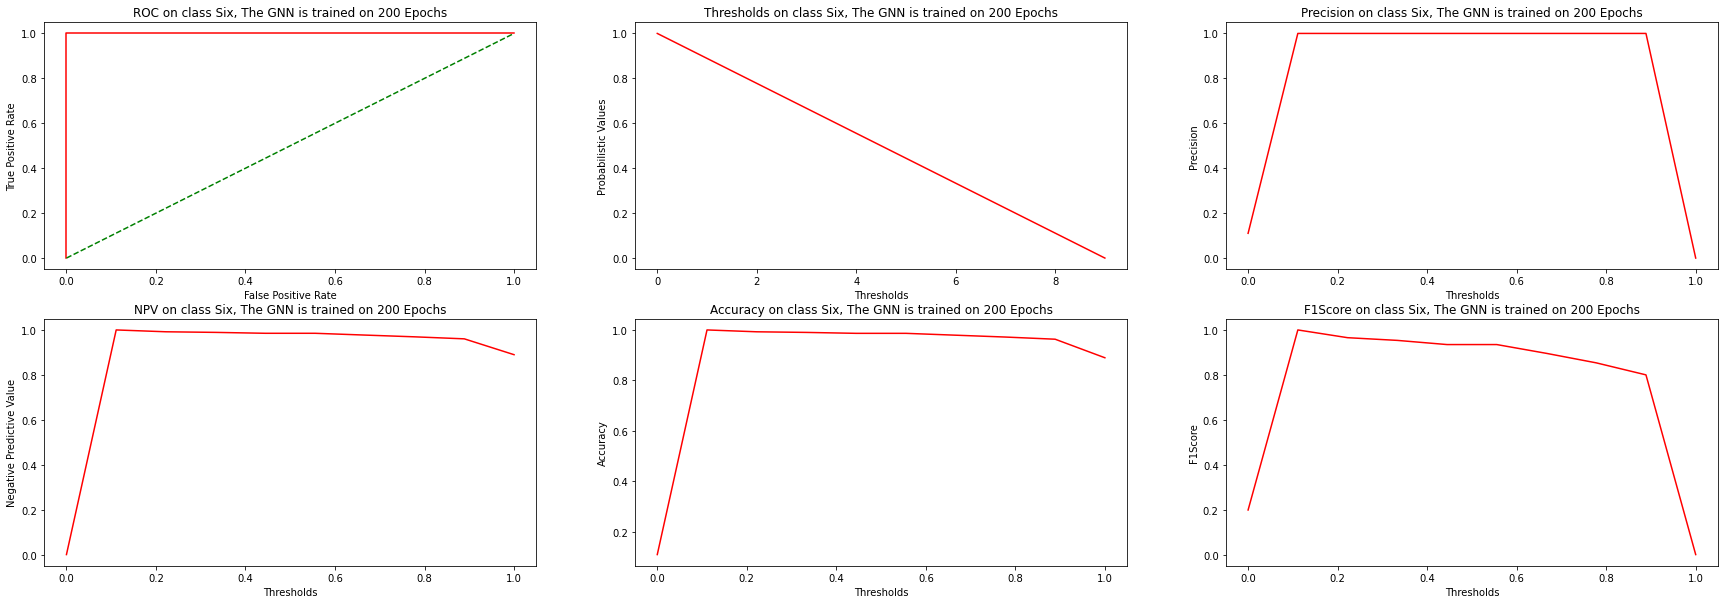

FPR:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 10
TPR:  [0.0, 0.6666666666666666, 0.7444444444444445, 0.8111111111111111, 0.8777777777777778, 0.8777777777777778, 0.9111111111111111, 0.9333333333333333, 1.0, 1.0] 10
Threshold:  [1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ] 10
Precision:  [0.0, 0.9999999999983333, 0.9999999999985074, 0.9999999999986301, 0.9999999999987341, 0.9999999999987341, 0.9999999999987804, 0.9999999999988095, 0.9999999999988889, 0.1101591187270367] 10
NPV:  [0.8898408812728409, 0.9603698811095164, 0.969333333333204, 0.9771505376342772, 0.9850948509483759, 0.9850948509483759, 0.9891156462583688, 0.991814461118555, 0.9999999999998623, 0.0] 10
Accuracy:  [0.8898408812729498, 0.9632802937576499, 0.9718482252141983, 0.9791921664626683, 0.9865361077111383, 0.9865361077111383, 0.9902080783353733, 0.99265605875153, 1.0, 0.11015911872705018] 10
F1Score:  [0.0, 0.8, 0.8535031847133758, 0.89570552147

In [67]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr6, tpr6, threshold6, precision_list6, npv_list6, acc_list6, f1score_list6],"Six")

print("FPR: ", fpr6, len(fpr6))
print("TPR: ", tpr6, len(tpr6))
print("Threshold: ", threshold6, len(threshold6))
print("Precision: ", precision_list6, len(precision_list6))
print("NPV: ", npv_list6, len(npv_list6))
print("Accuracy: ", acc_list6, len(acc_list6))
print("F1Score: ", f1score_list6, len(f1score_list6))

## **Class Seven**

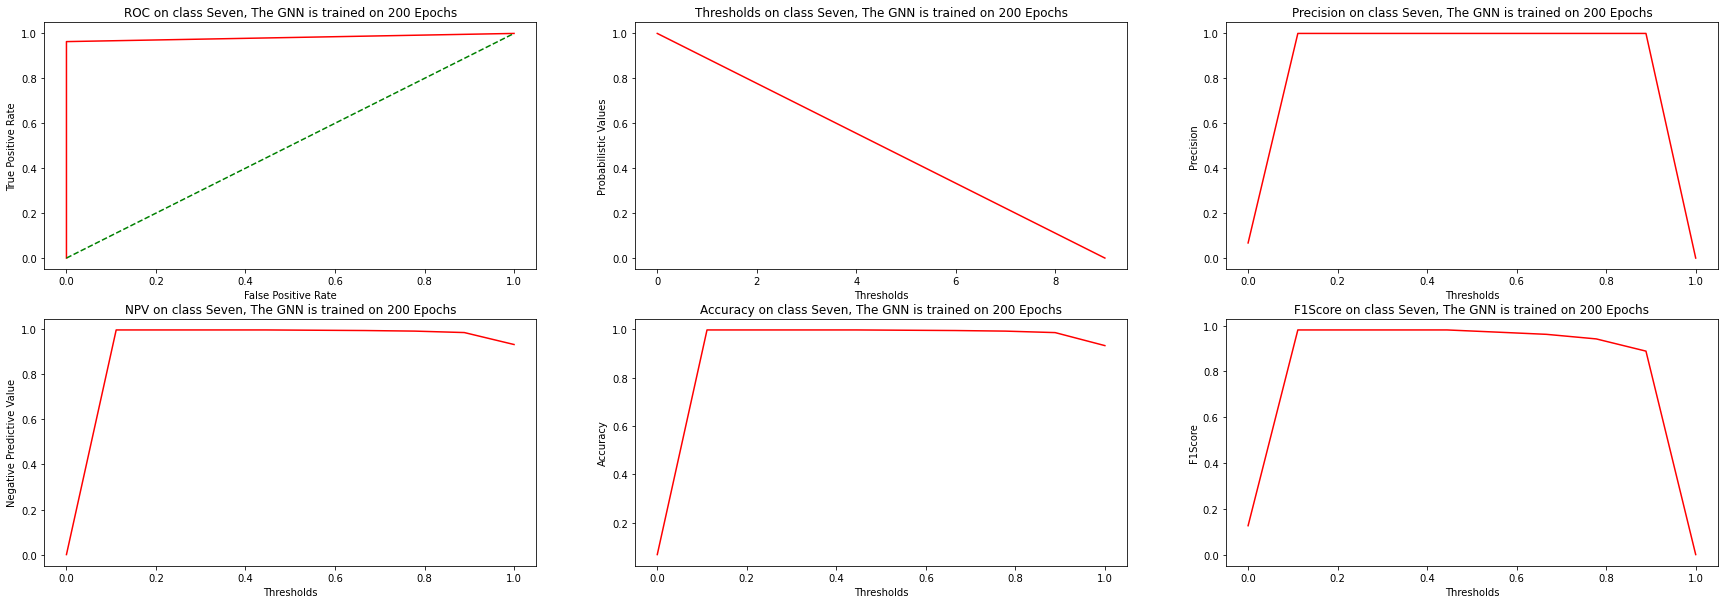

FPR:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 10
TPR:  [0.0, 0.8, 0.8909090909090909, 0.9272727272727272, 0.9454545454545454, 0.9636363636363636, 0.9636363636363636, 0.9636363636363636, 0.9636363636363636, 1.0] 10
Threshold:  [1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
 0.33333333 0.22222222 0.11111111 0.        ] 10
Precision:  [0.0, 0.9999999999977273, 0.9999999999979592, 0.9999999999980392, 0.9999999999980769, 0.9999999999981132, 0.9999999999981132, 0.9999999999981132, 0.9999999999981132, 0.0673194614443002] 10
NPV:  [0.9326805385555773, 0.9857697283310497, 0.9921874999998708, 0.9947780678849876, 0.9960784313724188, 0.9973821989527489, 0.9973821989527489, 0.9973821989527489, 0.9973821989527489, 0.0] 10
Accuracy:  [0.9326805385556916, 0.9865361077111383, 0.99265605875153, 0.9951040391676866, 0.996328029375765, 0.9975520195838433, 0.9975520195838433, 0.9975520195838433, 0.9975520195838433, 0.06731946144430845] 10
F1Score:  [0.0, 0.8888888888888888, 0.

In [68]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr7, tpr7, threshold7, precision_list7, npv_list7, acc_list7, f1score_list7],"Seven")

print("FPR: ", fpr7, len(fpr7))
print("TPR: ", tpr7, len(tpr7))
print("Threshold: ", threshold7, len(threshold7))
print("Precision: ", precision_list7, len(precision_list7))
print("NPV: ", npv_list7, len(npv_list7))
print("Accuracy: ", acc_list7, len(acc_list7))
print("F1Score: ", f1score_list7, len(f1score_list7))